# Sentence BERT — 문장 단위 분석

각 Abstract를 **문장 단위**로 분해한 뒤 Sentence BERT 임베딩을 적용합니다.

| 단계 | 내용 |
|------|------|
| 1 | 데이터 로드 & 연도 선택 |
| 2 | Kiwi로 문장 분리 |
| 3 | Sentence BERT 임베딩 |
| 4 | UMAP 시각화 |
| 5 | HDBSCAN 클러스터링 |
| 6 | 클러스터별 키워드 (TF-IDF) |
| 7 | 인터랙티브 시각화 (Plotly) |
| 8 | 문서 수준 집계 (문장 → 논문) |
| 9 | 유사 문장 검색 |

**모델**: `snunlp/KR-SBERT-V40K-klueNLI-augSTS`  
**문장 분리**: `kiwipiepy`

## 0. 라이브러리 로드

In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import platform, re

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_PATH = Path('abstract_year_data.csv')
print('라이브러리 로드 완료')

라이브러리 로드 완료


## 1. 데이터 로드 & 연도 선택

In [18]:
df_raw = pd.read_csv(DATA_PATH, encoding='utf-8-sig')
df_raw = df_raw.dropna(subset=['abstract']).copy()
df_raw['abstract'] = df_raw['abstract'].astype(str).str.strip()
df_raw = df_raw[df_raw['abstract'].str.len() > 20].reset_index(drop=True)

print(f'전체 데이터: {len(df_raw):,}건')
print(f'연도 범위: {df_raw["year"].min()} ~ {df_raw["year"].max()}')
print(df_raw['year'].value_counts().sort_index())

전체 데이터: 2,664건
연도 범위: 2018 ~ 2025
year
2018      36
2019      42
2020      73
2021     134
2022     177
2023     294
2024     531
2025    1377
Name: count, dtype: int64


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

_all_years = sorted(df_raw['year'].dropna().unique().astype(int).tolist())
_year_min, _year_max = min(_all_years), max(_all_years)

_mode = widgets.RadioButtons(
    options=['연도 범위 선택', '특정 연도 선택'],
    value='연도 범위 선택',
    description='선택 방식:',
    style={'description_width': '90px'},
    layout=widgets.Layout(width='320px')
)

_slider = widgets.IntRangeSlider(
    value=[_year_min, _year_max],
    min=_year_min, max=_year_max, step=1,
    description='연도 범위:',
    continuous_update=False,
    style={'description_width': '90px'},
    layout=widgets.Layout(width='480px')
)

_multi = widgets.SelectMultiple(
    options=_all_years,
    value=_all_years,
    description='연도 선택:',
    rows=min(len(_all_years), 10),
    style={'description_width': '90px'},
    layout=widgets.Layout(width='320px', height='180px', display='none')
)

_apply_btn = widgets.Button(description='적용', button_style='success',
                             layout=widgets.Layout(width='90px', margin='8px 0 0 0'))
_reset_btn = widgets.Button(description='전체 초기화', button_style='warning',
                             layout=widgets.Layout(width='110px', margin='8px 0 0 8px'))
_out = widgets.Output()

# 전역 변수 초기화
df = df_raw.copy()
SENT_CACHE    = Path('sent_embeddings_all.npy')
SENT_META     = Path('sent_meta_all.csv')
UMAP_CACHE_2D = Path('sent_umap_2d_all.npy')

def _on_mode(change):
    if change['new'] == '연도 범위 선택':
        _slider.layout.display = ''
        _multi.layout.display = 'none'
    else:
        _slider.layout.display = 'none'
        _multi.layout.display = ''

_mode.observe(_on_mode, names='value')

def _apply(b):
    global df, SENT_CACHE, SENT_META, UMAP_CACHE_2D
    with _out:
        clear_output()
        if _mode.value == '연도 범위 선택':
            y1, y2 = _slider.value
            selected = [y for y in _all_years if y1 <= y <= y2]
        else:
            selected = sorted(list(_multi.value))

        df = df_raw[df_raw['year'].isin(selected)].reset_index(drop=True)
        tag = f'{selected[0]}_{selected[-1]}'
        SENT_CACHE    = Path(f'sent_embeddings_{tag}.npy')
        SENT_META     = Path(f'sent_meta_{tag}.csv')
        UMAP_CACHE_2D = Path(f'sent_umap_2d_{tag}.npy')

        print(f'선택 연도: {selected[0]} ~ {selected[-1]}  ({len(selected)}개 연도)')
        print(f'논문 수: {len(df):,}건')
        print(f'캐시 파일: {SENT_CACHE.name}')
        print()
        print(df['year'].value_counts().sort_index().rename('건수').to_frame().T.to_string())
        print('아래 셀들을 순서대로 실행하세요.')

def _reset(b):
    global df, SENT_CACHE, SENT_META, UMAP_CACHE_2D
    with _out:
        clear_output()
        df = df_raw.copy()
        SENT_CACHE    = Path('sent_embeddings_all.npy')
        SENT_META     = Path('sent_meta_all.csv')
        UMAP_CACHE_2D = Path('sent_umap_2d_all.npy')
        _slider.value = [_year_min, _year_max]
        _multi.value = _all_years
        print(f'전체 초기화: {len(df):,}건')

_apply_btn.on_click(_apply)
_reset_btn.on_click(_reset)

display(widgets.VBox([
    _mode, _slider, _multi,
    widgets.HBox([_apply_btn, _reset_btn]),
    _out
]))

## 2. 문장 분리 (Kiwi)

각 abstract를 `kiwipiepy`로 문장 단위로 분리합니다.  
결과는 `df_sent` (문장 단위 DataFrame)에 저장됩니다.

In [20]:
from kiwipiepy import Kiwi

# 캐시 확인
if SENT_META.exists():
    df_sent = pd.read_csv(SENT_META, encoding='utf-8-sig')
    print(f'캐시 로드: {SENT_META.name}  ({len(df_sent):,}개 문장)')
else:
    kiwi = Kiwi()
    print(f'Kiwi 문장 분리 시작... (논문 {len(df):,}건)')

    rows = []
    for doc_idx, row in df.iterrows():
        try:
            sents = kiwi.split_into_sents(row['abstract'])
            for s_idx, s in enumerate(sents):
                text = s.text.strip()
                # 너무 짧은 문장(10자 미만) 제외
                if len(text) < 10:
                    continue
                rows.append({
                    'doc_idx': doc_idx,
                    'sent_idx': s_idx,
                    'year': row['year'],
                    'sentence': text,
                    'abstract': row['abstract'][:100]  # 원본 abstract 앞부분
                })
        except Exception:
            continue

        if (doc_idx + 1) % 500 == 0:
            print(f'  처리: {doc_idx+1}/{len(df)}')

    df_sent = pd.DataFrame(rows).reset_index(drop=True)
    df_sent.to_csv(SENT_META, index=False, encoding='utf-8-sig')
    print(f'완료: {len(df_sent):,}개 문장  ({SENT_META.name} 저장)')

print(f'\n논문 1건당 평균 문장 수: {len(df_sent)/len(df):.1f}개')
print(f'최소 문장 길이: {df_sent["sentence"].str.len().min()}자')
print(f'최대 문장 길이: {df_sent["sentence"].str.len().max()}자')
df_sent.head(5)

Kiwi 문장 분리 시작... (논문 2,513건)
  처리: 500/2513
  처리: 1000/2513
  처리: 1500/2513
  처리: 2000/2513
  처리: 2500/2513
완료: 20,850개 문장  (sent_meta_2021_2025.csv 저장)

논문 1건당 평균 문장 수: 8.3개
최소 문장 길이: 11자
최대 문장 길이: 4150자


doc_idx  sent_idx  year  \
0        0         0  2022   
1        1         0  2025   
2        1         1  2025   
3        1         2  2025   
4        1         3  2025   

                                                                                                                                                                                                  sentence  \
0  This paper compares the A.I. Pengtalk’s and English native speakers’ assessment of Korean-speaking children’s English pronunciation. For this, 60 sixth-graders participated as assessees and four E...   
1                                                                                                                       본 연구는 인공지능(AI) 기반 학습 시스템을 수학교육에 적용하여 학습자의 정의적 영역 변화를 분석하고 그 교육적 함의를 탐색하는 데 목적이 있다.   
2                                                                                                         고등학교 <인공지능 수학> 과목의 ‘퍼셉트론(Perceptron)’ 개념을 중심으로 AI 기반 학습 시스템을 개발하여 자동 채점, 단계별 피드백, 재도전 기회를 제공하였다.   
3                                                                                                            전라북도 소재 일반계 고등학교 1, 2학년 19명을 대상으로 3차시 수업을 실시하고, 수학에 대한 흥미・자신감・학습의욕・가치의 네 영역을 사전–사후 검사로 분석하였다.   
4                                                                                                                                      대응표본 t-검정 결과, 흥미, 학습의욕, 가치 영역에서 통계적으로 유의한 향상이 나타났으며, 자신감은 유의하지 않았다.   

                                                                                               abstract  
0  This paper compares the A.I. Pengtalk’s and English native speakers’ assessment of Korean-speaking c  
1  본 연구는 인공지능(AI) 기반 학습 시스템을 수학교육에 적용하여 학습자의 정의적 영역 변화를 분석하고 그 교육적 함의를 탐색하는 데 목적이 있다. 고등학교 <인공지능 수학> 과목  
2  본 연구는 인공지능(AI) 기반 학습 시스템을 수학교육에 적용하여 학습자의 정의적 영역 변화를 분석하고 그 교육적 함의를 탐색하는 데 목적이 있다. 고등학교 <인공지능 수학> 과목  
3  본 연구는 인공지능(AI) 기반 학습 시스템을 수학교육에 적용하여 학습자의 정의적 영역 변화를 분석하고 그 교육적 함의를 탐색하는 데 목적이 있다. 고등학교 <인공지능 수학> 과목  
4  본 연구는 인공지능(AI) 기반 학습 시스템을 수학교육에 적용하여 학습자의 정의적 영역 변화를 분석하고 그 교육적 함의를 탐색하는 데 목적이 있다. 고등학교 <인공지능 수학> 과목

## 3. Sentence BERT 임베딩

In [21]:
from sentence_transformers import SentenceTransformer

MODEL_NAME = 'snunlp/KR-SBERT-V40K-klueNLI-augSTS'
model = SentenceTransformer(MODEL_NAME)
print(f'모델 로드: {MODEL_NAME}')

모델 로드: snunlp/KR-SBERT-V40K-klueNLI-augSTS


In [22]:
if SENT_CACHE.exists():
    sent_embeddings = np.load(SENT_CACHE)
    print(f'캐시 로드: {SENT_CACHE.name}  {sent_embeddings.shape}')
else:
    sentences = df_sent['sentence'].tolist()
    print(f'임베딩 시작: {len(sentences):,}개 문장...')
    sent_embeddings = model.encode(
        sentences,
        batch_size=128,
        show_progress_bar=True,
        normalize_embeddings=True
    )
    np.save(SENT_CACHE, sent_embeddings)
    print(f'완료 & 저장: {sent_embeddings.shape}')

print(f'임베딩 차원: {sent_embeddings.shape}  (문장 수 x 768)')

임베딩 시작: 20,850개 문장...


Batches:   0%|          | 0/163 [00:00<?, ?it/s]

완료 & 저장: (20850, 768)
임베딩 차원: (20850, 768)  (문장 수 x 768)


## 4. UMAP 차원 축소

In [23]:
import umap

if UMAP_CACHE_2D.exists():
    umap_2d = np.load(UMAP_CACHE_2D)
    print(f'캐시 로드: {UMAP_CACHE_2D.name}')
else:
    print('UMAP 2D 차원 축소 중...')
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='cosine',
        random_state=42
    )
    umap_2d = reducer.fit_transform(sent_embeddings)
    np.save(UMAP_CACHE_2D, umap_2d)
    print('완료')

df_sent['umap_x'] = umap_2d[:, 0]
df_sent['umap_y'] = umap_2d[:, 1]
print(f'UMAP 좌표 추가 완료: {umap_2d.shape}')

UMAP 2D 차원 축소 중...
완료
UMAP 좌표 추가 완료: (20850, 2)


## 5. HDBSCAN 클러스터링

In [24]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(umap_2d)

df_sent['cluster'] = cluster_labels
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
noise_ratio = (cluster_labels == -1).sum() / len(cluster_labels) * 100

print(f'클러스터 수: {n_clusters}')
print(f'노이즈 비율: {noise_ratio:.1f}%')
print('클러스터별 문장 수:')
print(pd.Series(cluster_labels).value_counts().sort_index())

클러스터 수: 10
노이즈 비율: 1.2%
클러스터별 문장 수:
-1      258
 0     2791
 1       82
 2       42
 3       48
 4       63
 5       62
 6       32
 7      104
 8       93
 9    17275
Name: count, dtype: int64


## 6. 클러스터별 키워드 (TF-IDF)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

valid_clusters = [c for c in sorted(set(cluster_labels)) if c != -1]

cluster_docs = {}
for c in valid_clusters:
    texts = df_sent[df_sent['cluster'] == c]['sentence'].tolist()
    cluster_docs[c] = ' '.join(texts)

tfidf = TfidfVectorizer(
    tokenizer=lambda t: re.findall(r'[가-힣]{2,}', t),
    max_features=5000,
    min_df=1
)
corpus = [cluster_docs[c] for c in valid_clusters]
tfidf_matrix = tfidf.fit_transform(corpus)
feature_names = tfidf.get_feature_names_out()

print('클러스터별 상위 키워드 (TF-IDF):')
print('='*70)
cluster_keywords = {}
for idx, c in enumerate(valid_clusters):
    row = tfidf_matrix[idx].toarray().flatten()
    top_idx = row.argsort()[::-1][:10]
    keywords = [feature_names[i] for i in top_idx if row[i] > 0]
    cluster_keywords[c] = keywords
    n_sents = (df_sent['cluster'] == c).sum()
    print(f'클러스터 {c:2d} ({n_sents:5,}문장): {" | ".join(keywords[:8])}')

클러스터별 상위 키워드 (TF-IDF):
클러스터  0 (2,791문장): 인공지능 | 있다 | 연구는 | 목적이 | 대한 | 기술의 | 목적은 | 연구의
클러스터  1 (   82문장): 오리 | 개체를 | 검출 | 객체 | 개별 | 실시간으로 | 위해 | 검출하는
클러스터  2 (   42문장): 기초교육의 | 학생들이 | 플랫폼 | 체계화하여 | 보편적 | 교과목을 | 프로젝트 | 있는
클러스터  3 (   48문장): 골프 | 체육 | 기반 | 교육적 | 수업 | 적용 | 다층적으로 | 가능성과
클러스터  4 (   63문장): 한국프로야구 | 투구 | 투수의 | 모델을 | 인공지능 | 연구의 | 예측 | 기법을
클러스터  5 (   62문장): 교직 | 기반 | 간호대학생의 | 적응형 | 간호학과 | 연구는 | 약물용량계산 | 생성형
클러스터  6 (   32문장): 학생들은 | 소수의 | 학생들의 | 시각화를 | 탐구 | 실제로 | 깊이 | 개념을
클러스터  7 (  104문장): 다음과 | 같다 | 결과는 | 연구 | 연구의 | 주요 | 연구를 | 같은
클러스터  8 (   93문장): 프랑스어 | 읽기 | 교육 | 개정 | 교수 | 연구는 | 언어 | 학습
클러스터  9 (17,275문장): 생성형 | 학습 | 인공지능 | 연구는 | 있다 | 결과 | 교육 | 대한


## 7. 시각화

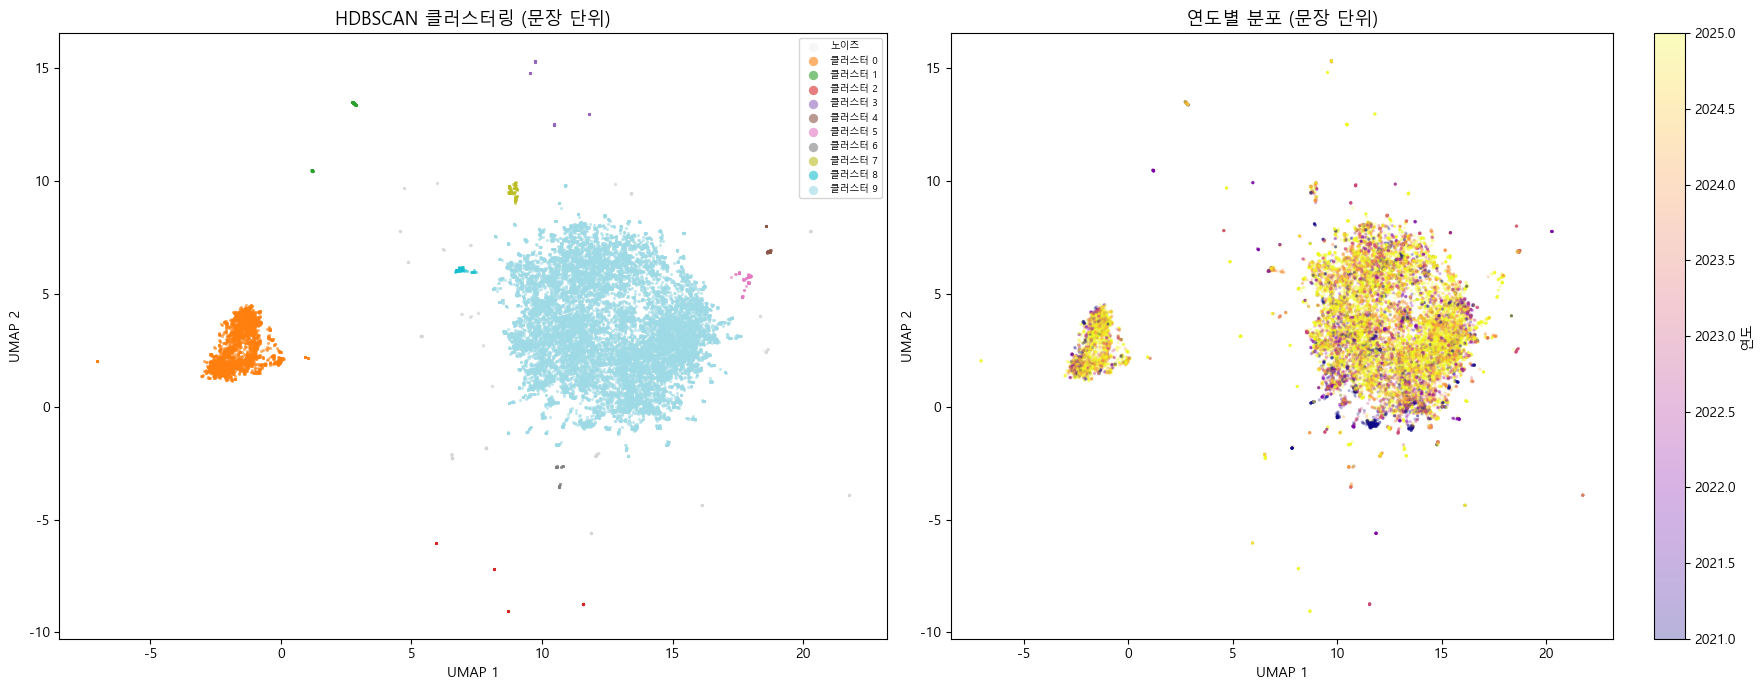

sent_umap_visualization.png 저장


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 좌: 클러스터별
ax = axes[0]
unique_clusters = sorted(set(cluster_labels))
cmap = plt.cm.get_cmap('tab20', max(len(unique_clusters), 1))
for i, c in enumerate(unique_clusters):
    mask = df_sent['cluster'] == c
    color = 'lightgray' if c == -1 else cmap(i)
    alpha = 0.2 if c == -1 else 0.6
    label = '노이즈' if c == -1 else f'클러스터 {c}'
    ax.scatter(df_sent.loc[mask, 'umap_x'], df_sent.loc[mask, 'umap_y'],
               c=[color], alpha=alpha, s=5, linewidths=0, label=label)

ax.set_title('HDBSCAN 클러스터링 (문장 단위)', fontsize=13)
ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2')
if n_clusters <= 15:
    ax.legend(markerscale=3, fontsize=7, loc='best')

# 우: 연도별
ax2 = axes[1]
sc = ax2.scatter(df_sent['umap_x'], df_sent['umap_y'],
                 c=df_sent['year'], cmap='plasma', alpha=0.3, s=5, linewidths=0)
plt.colorbar(sc, ax=ax2, label='연도')
ax2.set_title('연도별 분포 (문장 단위)', fontsize=13)
ax2.set_xlabel('UMAP 1'); ax2.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('sent_umap_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print('sent_umap_visualization.png 저장')

In [27]:
import plotly.express as px

df_sent['cluster_str'] = df_sent['cluster'].astype(str)
df_sent['sent_short'] = df_sent['sentence'].str[:120] + '...'
df_sent['keywords'] = df_sent['cluster'].map(
    lambda c: ' / '.join(cluster_keywords.get(c, ['노이즈'])[:5])
)

fig = px.scatter(
    df_sent,
    x='umap_x', y='umap_y',
    color='cluster_str',
    hover_data={'sent_short': True, 'year': True, 'keywords': True,
                'umap_x': False, 'umap_y': False, 'cluster_str': False},
    title='Sentence BERT — 문장 단위 UMAP + HDBSCAN',
    labels={'cluster_str': '클러스터', 'umap_x': 'UMAP 1', 'umap_y': 'UMAP 2'},
    opacity=0.5, width=950, height=670
)
fig.update_traces(marker=dict(size=3))
fig.write_html('sent_umap_interactive.html')
fig.show()
print('sent_umap_interactive.html 저장')

sent_umap_interactive.html 저장


## 8. 문서 수준 집계 (문장 임베딩 → 논문 임베딩)

각 논문에 속한 문장 임베딩의 **평균**을 계산하여 논문 단위 표현을 생성합니다.

In [28]:
# 논문별 문장 임베딩 평균 (mean pooling)
doc_embed_rows = []
for doc_idx, grp in df_sent.groupby('doc_idx'):
    idxs = grp.index.tolist()
    mean_vec = sent_embeddings[idxs].mean(axis=0)
    mean_vec /= (np.linalg.norm(mean_vec) + 1e-10)  # 정규화
    doc_embed_rows.append({'doc_idx': doc_idx, 'year': grp['year'].iloc[0],
                           'n_sents': len(grp)})

df_doc = pd.DataFrame(doc_embed_rows)
doc_embeddings = np.vstack([
    sent_embeddings[df_sent[df_sent['doc_idx'] == r['doc_idx']].index].mean(axis=0)
    for _, r in df_doc.iterrows()
])

print(f'문서 임베딩 shape: {doc_embeddings.shape}')
print(f'논문당 평균 문장 수: {df_doc["n_sents"].mean():.1f}')
df_doc.head()

문서 임베딩 shape: (2513, 768)
논문당 평균 문장 수: 8.3


doc_idx  year  n_sents
0        0  2022        1
1        1  2025        7
2        2  2024        8
3        3  2025       20
4        4  2025        1

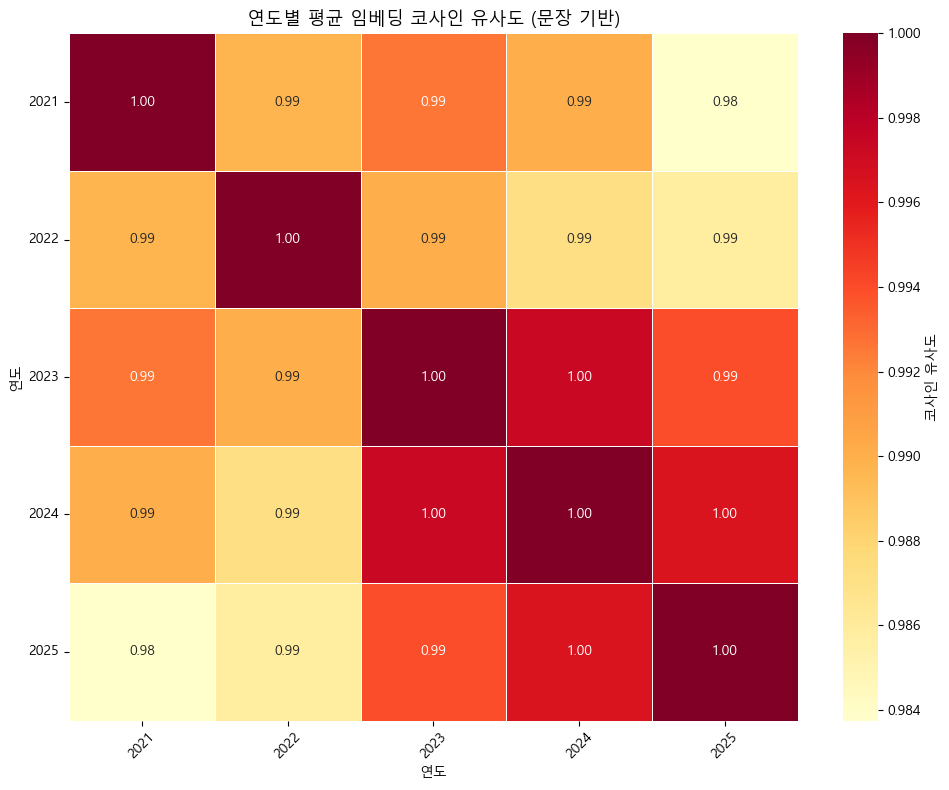

sent_year_heatmap.png 저장


In [29]:
# 연도별 문서 임베딩 중심 코사인 유사도 히트맵
from sklearn.metrics.pairwise import cosine_similarity

year_centroids = {}
for year, grp in df_doc.groupby('year'):
    year_centroids[year] = doc_embeddings[grp.index].mean(axis=0)

years_sorted = sorted(year_centroids.keys())
centroid_matrix = np.array([year_centroids[y] for y in years_sorted])
centroid_norm = centroid_matrix / np.linalg.norm(centroid_matrix, axis=1, keepdims=True)
sim_matrix = cosine_similarity(centroid_norm)

sim_df = pd.DataFrame(sim_matrix, index=years_sorted, columns=years_sorted)

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.eye(len(years_sorted), dtype=bool)
sns.heatmap(sim_df, annot=True, fmt='.2f', cmap='YlOrRd',
            vmin=sim_matrix[~mask].min(), vmax=1,
            linewidths=0.5, ax=ax, cbar_kws={'label': '코사인 유사도'})
ax.set_title('연도별 평균 임베딩 코사인 유사도 (문장 기반)', fontsize=13)
ax.set_xlabel('연도'); ax.set_ylabel('연도')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('sent_year_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('sent_year_heatmap.png 저장')

## 9. 유사 문장 검색

In [30]:
def find_similar_sentences(query: str, top_k: int = 10, year_filter: list = None):
    """쿼리 텍스트와 의미적으로 유사한 문장을 반환합니다."""
    query_embed = model.encode([query], normalize_embeddings=True)
    sims = cosine_similarity(query_embed, sent_embeddings)[0]

    if year_filter:
        mask = df_sent['year'].isin(year_filter).values
        sims = np.where(mask, sims, -1)

    top_idx = sims.argsort()[::-1][:top_k]

    results = []
    for rank, idx in enumerate(top_idx, 1):
        if sims[idx] < 0:
            break
        results.append({
            '순위': rank,
            '유사도': round(float(sims[idx]), 4),
            '연도': int(df_sent.iloc[idx]['year']),
            '문장': df_sent.iloc[idx]['sentence']
        })
    return pd.DataFrame(results)

# 예시 검색
query_text = "인공지능을 활용한 영어 교육"
print(f'검색어: "{query_text}"')
pd.set_option('display.max_colwidth', 200)
find_similar_sentences(query_text, top_k=7)

검색어: "인공지능을 활용한 영어 교육"


순위     유사도    연도  \
0   1  0.7364  2024   
1   2  0.7364  2024   
2   3  0.7345  2025   
3   4  0.7285  2021   
4   5  0.7204  2025   
5   6  0.7146  2024   
6   7  0.7131  2024   

                                                                    문장  
0           영어 인공지능 시스템인 AI 펭톡은 초등학교 학습자를 위해 제작된 맞춤형 인공지능 말하기 연습시스템이다.  
1           영어 인공지능 시스템인 AI 펭톡은 초등학교 학습자를 위해 제작된 맞춤형 인공지능 말하기 연습시스템이다.  
2     생성형 인공지능(AI)이 교육의 학습도구로 활용됨에 따라 영어학습에서도 이를 이용하려는시도가 활발히 진행되고 있다.  
3              본 연구는 AI융합 교실에 필요한 초등학교 예비교사들의 영어교과 교수요목을 개발하는 것이 목표이다.  
4                                        생성형 AI를 활용한 영어 쓰기능력 향상에 관한 연구  
5  셋째, 수업설계의 각 단계에서 인공지능이 활용될 수 있도록 인공지능 기반 수학 교수·학습 플랫폼에 대한 연구가 필요하다.  
6           둘째, 인공지능을 활용한 수학교육이 활성화될 수 있도록 인공지능 활용 수업자료 개발 및 보급이 필요하다.

In [31]:
# 연도를 지정한 검색 예시
query_text2 = "챗봇 기반 언어 학습"
print(f'검색어: "{query_text2}"  (2020년 이후만)')
find_similar_sentences(query_text2, top_k=7, year_filter=[2020, 2021, 2022, 2023, 2024, 2025])

검색어: "챗봇 기반 언어 학습"  (2020년 이후만)


순위     유사도    연도  \
0   1  0.7895  2024   
1   2  0.7895  2024   
2   3  0.7895  2024   
3   4  0.7803  2023   
4   5  0.7758  2022   
5   6  0.7710  2025   
6   7  0.7492  2022   

                                                                         문장  
0                     생성형 AI 기반 챗봇은 자연스러운 의사소통을 통한 학생 맞춤형 교육이 가능하다는 장점이 있다.  
1                     생성형 AI 기반 챗봇은 자연스러운 의사소통을 통한 학생 맞춤형 교육이 가능하다는 장점이 있다.  
2                     생성형 AI 기반 챗봇은 자연스러운 의사소통을 통한 학생 맞춤형 교육이 가능하다는 장점이 있다.  
3  본 연구에서는 초등학생 저학년의 경우에도 쉽게 활용 가능하고 학습효과를 높일 수 있는 가르치기 방식의 AI 음성 챗봇을 제안한다.  
4                                사회과지역화 학습에서 AI 챗봇을 활용하는 것은 다음과 같은 장점을 지닌다.  
5           이에 본 연구는 AI 챗봇을 활용하여 개인화된 학습 경험과 상호작용을 제공함으로써 이러한 문제를 해결하고자 한다.  
6                    첫째, 인공지능 챗봇을 활용하여 학습자의 창의적 아이디어 발산을 지원하는 도구를 개발할 수 있다.

## 10. 결과 저장

In [32]:
# 문장 단위 결과
out_cols = ['doc_idx', 'sent_idx', 'year', 'cluster', 'umap_x', 'umap_y', 'sentence']
df_sent[out_cols].to_csv('sent_cluster_result.csv', index=False, encoding='utf-8-sig')
print('sent_cluster_result.csv 저장')

# 클러스터 요약
summary = []
for c in valid_clusters:
    mask = df_sent['cluster'] == c
    summary.append({
        '클러스터': c,
        '문장수': int(mask.sum()),
        '논문수': int(df_sent[mask]['doc_idx'].nunique()),
        '주요연도': int(df_sent[mask]['year'].mode().iloc[0]),
        '키워드': ' | '.join(cluster_keywords.get(c, [])[:8])
    })
pd.DataFrame(summary).to_csv('sent_cluster_summary.csv', index=False, encoding='utf-8-sig')
print('sent_cluster_summary.csv 저장')

print()
print('=== 분석 완료 ===')
for f in ['sent_embeddings_all.npy', 'sent_meta_all.csv', 'sent_umap_2d_all.npy',
          'sent_umap_visualization.png', 'sent_umap_interactive.html',
          'sent_year_heatmap.png', 'sent_cluster_result.csv', 'sent_cluster_summary.csv']:
    exists = 'O' if Path(f).exists() else 'X'
    print(f'  [{exists}] {f}')

sent_cluster_result.csv 저장
sent_cluster_summary.csv 저장

=== 분석 완료 ===
  [O] sent_embeddings_all.npy
  [O] sent_meta_all.csv
  [O] sent_umap_2d_all.npy
  [O] sent_umap_visualization.png
  [O] sent_umap_interactive.html
  [O] sent_year_heatmap.png
  [O] sent_cluster_result.csv
  [O] sent_cluster_summary.csv
